In [8]:
from collections import defaultdict
import rdkit
import rdkit.Chem as Chem
MST_MAX_WEIGHT = 100
def tree_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1: #special case
        return [[0]], []

    cliques = []                                #contain bonds not in rings with format [ [begin_atom1;end_atoms1],[begin_atom2;end_atoms2] ]
    for bond in mol.GetBonds():                     
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            print("Have Bond")
            cliques.append([a1,a2])

    ssr = [list(x) for x in Chem.GetSymmSSSR(mol)]
    cliques.extend(ssr)

    nei_list = [[] for i in range(n_atoms)]                 #nei_list = sublist (represent for each atom) in a list
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)                        #each sublist contain the information clique order that atom at
    print("cliq before merge:", cliques)

    #Merge Rings with intersection > 2 atoms
    for i in range(len(cliques)):
        if len(cliques[i]) <= 2: continue                   #if this is bond => move to next 
        for atom in cliques[i]:
            for j in nei_list[atom]:
                if i >= j or len(cliques[j]) <= 2: continue     #If i>j reduce the double time check between two clique, which is redundancy
                inter = set(cliques[i]) & set(cliques[j])
                if len(inter) > 2:
                    print("Have merging")
                    cliques[i].extend(cliques[j])
                    cliques[i] = list(set(cliques[i]))
                    cliques[j] = []
    #Clear back the nei_list after merging
    cliques = [c for c in cliques if len(c) > 0]
    nei_list = [[] for i in range(n_atoms)]
    for i in range(len(cliques)):
        for atom in cliques[i]:
            nei_list[atom].append(i)

    print('cliques after merge:', cliques)
    print('nei_list after merge:', nei_list)

    #Build edges and add singleton cliques
    edges = defaultdict(int)
    for atom in range(n_atoms):
        if len(nei_list[atom]) <= 1:                            #Ignore atom exist in only 1 clique
            continue
        cnei = nei_list[atom]
        bonds = [c for c in cnei if len(cliques[c]) == 2]       
        rings = [c for c in cnei if len(cliques[c]) > 4]
        if len(bonds) > 2 or (len(bonds) == 2 and len(cnei) > 2): #In general, if len(cnei) >= 3, a singleton should be added, but 1 bond + 2 ring is currently not dealt with.
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1,c2)] = 1
        elif len(rings) > 2: #Multiple (n>2) complex rings
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1,c2)] = MST_MAX_WEIGHT - 1
        else:
            for i in range(len(cnei)):
                for j in range(i + 1, len(cnei)):
                    c1,c2 = cnei[i],cnei[j]
                    inter = set(cliques[c1]) & set(cliques[c2])
                    if edges[(c1,c2)] < len(inter):
                        edges[(c1,c2)] = len(inter) #cnei[i] < cnei[j] by construction
    print("cliques added singleton", cliques)
    print("edge dict:", edges)
    edges = [u + (MST_MAX_WEIGHT-v,) for u,v in edges.items()]
    if len(edges) == 0:
        return cliques, edges
    else:
        return cliques, edges


In [4]:
from rdkit import Chem

# Create a molecule with multiple rings (naphthalene)
# smiles = 'c1ccc2c(c1)ccc3c2cccc3'  # SMILES notation for naphthalene
smiles = "CCN(Cc1nc2ccccc2c(=O)[nH]1)C(=O)CC1CCCC1"   #have_interection
mol = Chem.MolFromSmiles(smiles)

cliques, edges = tree_decomp(mol)
print("edge_list", edges)

Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
Have Bond
cliq before merge: [[0, 1], [1, 2], [2, 3], [3, 4], [12, 13], [2, 15], [15, 16], [15, 17], [17, 18], [5, 6, 11, 12, 14, 4], [7, 8, 9, 10, 11, 6], [19, 18, 22, 21, 20]]
cliques after merge: [[0, 1], [1, 2], [2, 3], [3, 4], [12, 13], [2, 15], [15, 16], [15, 17], [17, 18], [5, 6, 11, 12, 14, 4], [7, 8, 9, 10, 11, 6], [19, 18, 22, 21, 20]]
nei_list after merge: [[0], [0, 1], [1, 2, 5], [2, 3], [3, 9], [9], [9, 10], [10], [10], [10], [10], [9, 10], [4, 9], [4], [9], [5, 6, 7], [6], [7, 8], [8, 11], [11], [11], [11], [11]]
cliques added singleton [[0, 1], [1, 2], [2, 3], [3, 4], [12, 13], [2, 15], [15, 16], [15, 17], [17, 18], [5, 6, 11, 12, 14, 4], [7, 8, 9, 10, 11, 6], [19, 18, 22, 21, 20], [2], [15]]
edge dict: defaultdict(<class 'int'>, {(0, 1): 1, (1, 12): 1, (2, 12): 1, (5, 12): 1, (2, 3): 1, (3, 9): 1, (9, 10): 2, (4, 9): 1, (5, 13): 1, (6, 13): 1, (7, 13): 1, (7, 8): 1, (8, 11): 1})
edge_list [(

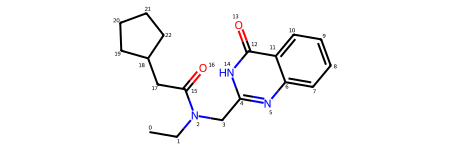

In [5]:
for atom in mol.GetAtoms():
    # For each atom, set the property "atomNote" to a index+1 of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))

mol

In [11]:
def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        display(atom)
        a = atom.SetAtomMapNum(num)
        print(a)

In [66]:
print(bonds)
print(rings)

[[5, 6], [11, 12], [0, 5, 4, 3, 2, 1], [7, 8, 9, 10, 11, 6], [13, 14, 15, 16, 17, 12]]
[[0, 6, 7, 3, 2, 1, 4, 3, 7, 6, 5], [4, 3, 7, 6, 5]]


In [67]:
n_atoms = mol.GetNumAtoms()

nei_list = [[] for i in range(n_atoms)]             #create number_of_atom sublist
for i in range(len(cliques)):
    print(i)
    for atom in cliques[i]:
        print(atom)
        nei_list[atom].append(i)

print(n_atoms)
print(cliques)
print(nei_list)

0
0
1
2
3
4
5
6
7
1
8
[[0, 1, 2, 3, 4, 5, 6, 7], []]
[[0], [0], [0], [0], [0], [0], [0], [0]]


In [79]:
print(cliques)
print(type(edges))


[[0, 1, 2, 3, 4, 5, 6, 7], []]
<class 'list'>


In [112]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

edges_check = defaultdict(int)

edges_check = {(0, 1): 1, (1, 12): 1, (2, 12): 1, (5, 12): 1, (2, 3): 1, (3, 9): 1, (9, 10): 2, (4, 9): 1, (5, 13): 1, (6, 13): 1, (7, 13): 1, (7, 8): 1, (8, 11): 1}
edges_list = [u + (MST_MAX_WEIGHT-v,) for u,v in edges_check.items()]
print(edges_list)
row,col,data = list(zip(*edges_list))
n_clique = len(cliques)
clique_graph = csr_matrix( (data,(row,col)), shape=(n_clique,n_clique) )
print(clique_graph)
junc_tree = minimum_spanning_tree(clique_graph)
print(junc_tree)
row,col = junc_tree.nonzero()
edges = [(row[i],col[i]) for i in range(len(row))]
# return (cliques, edges)

[(0, 1, 99), (1, 12, 99), (2, 12, 99), (5, 12, 99), (2, 3, 99), (3, 9, 99), (9, 10, 98), (4, 9, 99), (5, 13, 99), (6, 13, 99), (7, 13, 99), (7, 8, 99), (8, 11, 99)]
  (0, 1)	99
  (1, 12)	99
  (2, 3)	99
  (2, 12)	99
  (3, 9)	99
  (4, 9)	99
  (5, 12)	99
  (5, 13)	99
  (6, 13)	99
  (7, 8)	99
  (7, 13)	99
  (8, 11)	99
  (9, 10)	98
  (0, 1)	99.0
  (1, 12)	99.0
  (2, 3)	99.0
  (2, 12)	99.0
  (3, 9)	99.0
  (4, 9)	99.0
  (5, 12)	99.0
  (5, 13)	99.0
  (6, 13)	99.0
  (7, 8)	99.0
  (7, 13)	99.0
  (8, 11)	99.0
  (9, 10)	98.0


In [114]:
print(edges)

[(0, 1), (1, 12), (2, 3), (2, 12), (3, 9), (4, 9), (5, 12), (5, 13), (6, 13), (7, 8), (7, 13), (8, 11), (9, 10)]


In [109]:
row,col = junc_tree.nonzero()


In [111]:
col

array([ 1, 12,  3, 12,  9,  9, 12, 13, 13,  8, 13, 11, 10], dtype=int32)

In [125]:
def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom
def sanitize(mol):
    try:
        smiles = get_smiles(mol)
        mol = get_mol(smiles)
    except Exception as e:
        return None
    return mol
def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol
def get_clique_mol(mol, atoms):
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol) #We assume this is not None
    return new_mol

C1=CN=CNC1


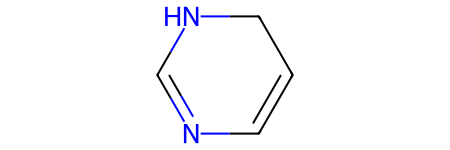

In [136]:
smiles = Chem.MolFragmentToSmiles(mol, (5, 6, 11, 12, 14, 4), kekuleSmiles=True)
print(smiles)
new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
new_mol = copy_edit_mol(new_mol).GetMol()
# new_mol = sanitize(new_mol) #We assume this is not None
new_mol


In [134]:
neww_mol = sanitize(new_mol) #We assume this is not None
neww_mol

In [141]:
class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):
        self.smiles = smiles
        self.mol = get_mol(self.smiles)

        self.clique = [x for x in clique] #copy
        self.neighbors = []



    def add_neighbor(self, nei_node):
        self.neighbors.append(nei_node)

    def recover(self, original_mol):
        clique = []
        clique.extend(self.clique)
        if not self.is_leaf:
            for cidx in self.clique:
                original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(self.nid)

        for nei_node in self.neighbors:
            clique.extend(nei_node.clique)
            if nei_node.is_leaf: #Leaf node, no need to mark 
                continue
            for cidx in nei_node.clique:
                #allow singleton node override the atom mapping
                if cidx not in self.clique or len(nei_node.clique) == 1:
                    atom = original_mol.GetAtomWithIdx(cidx)
                    atom.SetAtomMapNum(nei_node.nid)

        clique = list(set(clique))
        label_mol = get_clique_mol(original_mol, clique)
        self.label = Chem.MolToSmiles(Chem.MolFromSmiles(get_smiles(label_mol)))

        for cidx in clique:
            original_mol.GetAtomWithIdx(cidx).SetAtomMapNum(0)

        return self.label
    
    def assemble(self):
        neighbors = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in self.neighbors if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cands,aroma = enum_assemble(self, neighbors)
        new_cands = [cand for i,cand in enumerate(cands) if aroma[i] >= 0]
        if len(new_cands) > 0: cands = new_cands

        if len(cands) > 0:
            self.cands, _ = list(zip(*cands))
            self.cands = list(self.cands)
        else:
            self.cands = []

In [146]:
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol
node = MolTreeNode("C1=CN=CNC1", (5, 6, 11, 12, 14, 4))


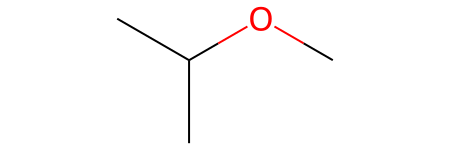